In [6]:
import sys
sys.path.append(r"I:/ML/工况合集")
print(sys.path)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from utils.PDE_Net import DeepONet_NS, weight_init
from utils.DataGenerate_DON import Dataset_DON
from torch.utils.tensorboard import SummaryWriter
from utils.utilities3 import *

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

['i:\\ML\\工况合集\\5训练集-0.5m窗口-split2（base）\\DON', 'h:\\Anaconda\\envs\\my_torch\\python310.zip', 'h:\\Anaconda\\envs\\my_torch\\DLLs', 'h:\\Anaconda\\envs\\my_torch\\lib', 'h:\\Anaconda\\envs\\my_torch', '', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages\\win32', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages\\win32\\lib', 'h:\\Anaconda\\envs\\my_torch\\lib\\site-packages\\Pythonwin', 'I:/ML/工况合集', 'I:/ML/工况合集']


In [7]:
dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
self_split = 2

epochs = 1000
step_size = 50

batch_size = 300
learning_rate = 0.01
weight_decay = 0.01
max_norm = 5

path_trained_model = r'trained_model'

path_label = r'I:\ML\工况合集\5训练集-0.5m窗口-split2（base）\train_data\label'

path_label_test = r'I:\ML\工况合集\5训练集-0.5m窗口-split2（base）\test_data\label'

In [13]:
dataset = Dataset_DON(path_label,n_x,n_y,p_x,p_y)
train_bc,train_label,train_coordinate,train_min,train_max = dataset.get_data()
print(train_bc.shape)
print(train_label.shape)
print(train_coordinate.shape)

torch.Size([1500, 204])
torch.Size([1500, 2601])
torch.Size([2601, 2])


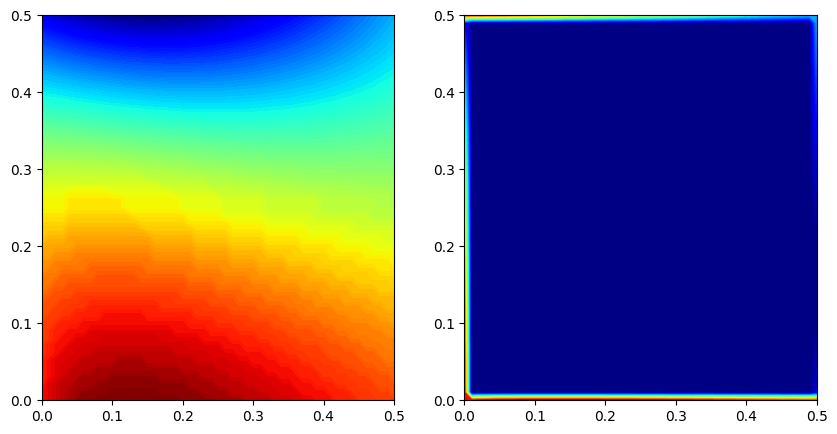

error


In [25]:
index = 50
y = train_label.reshape(-1,51,51)[index]
x = torch.zeros_like(y)
x[:,0] = train_bc[index,0:51]
x[:,-1] = train_bc[index,51:102]
x[-1,:] = train_bc[index,102:153]
x[0,:] = train_bc[index,153:204]
x1 = train_coordinate[:,0].reshape(51,51)
x2 = train_coordinate[:,1].reshape(51,51)
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs[0].contourf(x1,x2,y,100,cmap='jet',vmin=0, vmax=1)
axs[1].contourf(x1,x2,x,100,cmap='jet',vmin=0, vmax=1)
plt.show()
# print(max(y.reshape(-1)))
if torch.min(train_bc[index,0:51]) == torch.min(train_label.reshape(-1,51,51)[index,:,0].reshape(-1)):
	print('error')

In [ ]:
model = DeepONet_NS([204, 512, 512, 512, 512, 512], [2, 16, 64, 256, 512, 512, 512])
model.apply(weight_init)
model.to(device)
myloss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True, min_lr=1e-6)
begin_epoch = 0

加载模型

In [ ]:
file_list = os.listdir(path_trained_model)
if len(file_list) > 0:
	last_model = os.listdir(path_trained_model)[-1]
# save_path = os.path.join(path, 'model_{}.pth'.format(begin_epoch))
load_path = os.path.join(path_trained_model, last_model)
begin_epoch = load_model(load_path, optimizer, model)
model.to(device)

训练开始！

In [ ]:
epoch_num = 10000

dataset = Dataset_DON(path_label,n_x,n_y,p_x,p_y)
dataset_test = Dataset_DON(path_label_test,n_x,n_y,p_x,p_y)

train_bc,train_label,train_coordinate,train_min,train_max = dataset.get_data()
train_bc = torch.Tensor(train_bc).to(device)
train_coordinate = torch.Tensor(train_coordinate).to(device)
train_label = torch.Tensor(train_label).to(device)

test_bc,test_label,test_coordinate,test_min,test_max = dataset_test.get_data()
test_bc = torch.Tensor(test_bc).to(device)
test_coordinate = torch.Tensor(test_coordinate).to(device)
test_label = torch.Tensor(test_label).to(device)

for epoch in range(begin_epoch, epochs+1):
	model.train()

	pred = model(train_bc, train_coordinate)			# [train_size,1089]
	pred = dataset.inverse_normalize(pred,train_min,train_max)
	train_label = dataset.inverse_normalize(train_label,train_min,train_max)
	regularization_loss = 0
	for param in model.parameters():
		regularization_loss += torch.norm(param, p=2)
	loss_train = myloss(pred.clone(), train_label.clone())
	total_loss = loss_train + weight_decay * regularization_loss

	optimizer.zero_grad()
	total_loss.backward(retain_graph=True)
	torch.nn.utils.clip_grad_norm(model.parameters(), max_norm, norm_type=2)
	optimizer.step()
	print('epoch:', epoch, 'loss_train:', loss_train.item())
	scheduler.step(total_loss)

	model.eval()
	pred_test = model(test_bc, test_coordinate)			# [test_size,1089]
	pred_test = dataset_test.inverse_normalize(pred_test,test_min,test_max)
	test_label = dataset_test.inverse_normalize(test_label,test_min,test_max)

	loss_test = myloss(pred_test.clone(), test_label.clone())
	print('epoch:', epoch, 'loss_test:', loss_test.item())

	if epoch % 100 == 0:
		save_path = os.path.join(path_trained_model, 'DON_{}.pth'.format(epoch))
		save_model(save_path, epoch, optimizer, model)

操，失败了